# Installs

In [1]:
%pip install -U openai json-repair google-genai gliclass rapidfuzz "transformers>=4.48.0" retry ipywidgets widgetsnbextension pandas-profiling readtime optuna bertopic supabase

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Fetch events

In [2]:
import pandas as pd
from src.events import get_events # Assuming Event model is imported in events.py

sources, events = get_events(date="2025-05-08")

#sources, events = get_events() # Use this line if calling without date works

print(f"Number of events: {len(events)}")
print(f"Number of sources: {len(sources)}")

# Initialize articles_df OUTSIDE the if block, perhaps as None or empty
articles_df = None

if events: # Only proceed if the events list is NOT empty
    print("Processing events into DataFrame...")

    # Create DataFrame - Using .dict() assumes Event is Pydantic
    # Check if Event model in events.py actually has 10 or 11 fields! Let's assume 10 for now.
    try:
        # Use the actual Event objects directly if possible
        articles_df = pd.DataFrame([event.dict() for event in events])
        # OR create from raw data if Pydantic causes issues (less ideal)
        # events_data = data.get("events", []) # Need access to 'data' if using this
        # desired_columns = ["id", "sourceId", ..., "summary"] # 10 columns
        # articles_df = pd.DataFrame([{col: event.get(col) for col in desired_columns} for event in events_data])

        print("Columns IMMEDIATELY AFTER creation:", articles_df.columns)
        print(f"Number of columns IMMEDIATELY AFTER creation: {len(articles_df.columns)}")

        # Optional tuple cleanup loop (only if needed, unlikely with .dict())
        # Make sure this loop is correctly indented under 'if events:'
        # for col in articles_df.columns:
        #     articles_df[col] = articles_df[col].apply(
        #         lambda x: x[1] if isinstance(x, tuple) else x
        #     )

        # --- Processing AFTER the loop (if you had one), indented under 'if events:' ---

        # --- REMOVE the articles_df.columns = [...] assignment ---

        # Process summary
        # Add error handling in case 'summary' column doesn't exist or has None values
        if 'summary' in articles_df.columns:
            articles_df["summary_processed"] = ( # Use new column name initially
                articles_df["summary"].astype(str) # Ensure string type
                .str.split("EVENT:")
                .str[1] # Careful: might be None if "EVENT:" not present
                .str.split("CONTEXT:")
                .str[0] # Careful: might be None
                .str.strip()
            )
            # Handle potential None values after split if needed before creating text_to_embed
            articles_df["summary_processed"] = articles_df["summary_processed"].fillna('')
            articles_df["text_to_embed"] = "query: " + articles_df["summary_processed"]
            print("Created 'text_to_embed' column.")
        else:
            print("Warning: 'summary' column not found for processing.")


        print("DataFrame processing complete. First 5 rows:")
        print(articles_df.head())

    except Exception as e:
        print(f"An error occurred during DataFrame processing: {e}")
        # Keep articles_df as None or empty if processing fails
        articles_df = pd.DataFrame()


else: # This 'else' corresponds to 'if events:'
    print("No events found for the specified date. Skipping DataFrame processing.")
    articles_df = pd.DataFrame() # Create empty DF here

# --- REMOVE the final articles_df = pd.DataFrame() line that was outside the if/else ---

# Now, subsequent cells can check articles_df (it will be None or an empty/processed DataFrame)
print("\nFinished Cell 2 execution.")
if articles_df is not None and not articles_df.empty:
    print(f"Final articles_df shape: {articles_df.shape}")
else:
    print("Final articles_df is None or empty.")



----- DEBUG RESPONSE -----
Status Code: 200
Response Data: {'sources': [{'id': 904, 'name': 'Evening Standard UK'}, {'id': 905, 'name': 'The Conversation UK'}, {'id': 906, 'name': 'Manchester Evening News UK'}, {'id': 907, 'name': 'Daily Express News Showbiz (Feedburner) UK'}, {'id': 908, 'name': 'Metro UK'}, {'id': 910, 'name': 'Positive News'}, {'id': 911, 'name': 'London Journal'}, {'id': 913, 'name': 'The Guardian UK Environment'}, {'id': 887, 'name': 'Sky News Strange'}, {'id': 914, 'name': 'The Guardian Europe News'}, {'id': 915, 'name': 'The Guardian Science'}, {'id': 916, 'name': 'The Guardian UK Technology'}, {'id': 917, 'name': 'The Guardian US News'}, {'id': 918, 'name': 'The Guardian UK News'}, {'id': 919, 'name': 'The Guardian World'}, {'id': 920, 'name': 'UN News All'}, {'id': 921, 'name': 'UN News Human Rights'}, {'id': 1, 'name': 'BBC News Feed'}, {'id': 2, 'name': 'NBC News'}, {'id': 5, 'name': 'CNN World RSS Feed'}, {'id': 6, 'name': 'Al Jazeera RSS Feed'}, {'id': 9, 

C:\Users\phili\AppData\Local\Temp\ipykernel_23064\249117290.py:21: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  articles_df = pd.DataFrame([event.dict() for event in events])


# Clustering

## Prep: embeddings

In [3]:
print("entering clustering cell...")
import torch
import torch.nn.functional as F
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# helper function for pooling (straight from the docs)
def average_pool(last_hidden_states, attention_mask):
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

# load the multilingual model
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-small')


# batch processing to avoid memory issues
batch_size = 64
all_embeddings = []

# process in batches with progress bar
for i in tqdm(range(0, len(articles_df), batch_size)):
    batch_texts = articles_df['text_to_embed'].iloc[i:i+batch_size].tolist()
    
    # tokenize
    batch_dict = tokenizer(batch_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    # generate embeddings
    with torch.no_grad():
        outputs = model(**batch_dict)
    
    # pool and normalize
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    # convert to numpy and add to list
    all_embeddings.extend(embeddings.numpy())

# store in dataframe
articles_df['embedding'] = all_embeddings
print("...finished the clustering cell")

entering clustering cell...


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.03it/s]

...finished the clustering cell


## Grid search umap & hdbscan params

In [4]:
import numpy as np
import hdbscan
import umap
from hdbscan.validity import validity_index


def optimize_clusters(embeddings, umap_params, hdbscan_params):
    best_score = -1
    best_params = None

    # grid search both umap and hdbscan params
    for n_neighbors in umap_params["n_neighbors"]:
        # fit umap once per n_neighbors config
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            n_components=10,
            min_dist=0.0,
            metric="cosine",
            random_state=42,
        )
        reduced_data = reducer.fit_transform(embeddings)

        for min_cluster_size in hdbscan_params["min_cluster_size"]:
            for min_samples in hdbscan_params["min_samples"]:
                for epsilon in hdbscan_params["epsilon"]:
                    # cluster with hdbscan
                    clusterer = hdbscan.HDBSCAN(
                        min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        cluster_selection_epsilon=epsilon,
                        metric="euclidean",
                        prediction_data=True,
                    )

                    cluster_labels = clusterer.fit_predict(reduced_data)

                    # skip if all noise
                    if np.all(cluster_labels == -1):
                        continue

                    # evaluate with dbcv (better for density clusters)
                    valid_points = cluster_labels != -1
                    if (
                        valid_points.sum() > 1
                        and len(set(cluster_labels[valid_points])) > 1
                    ):
                        try:
                            reduced_data_64 = reduced_data[valid_points].astype(
                                np.float64
                            )
                            score = validity_index(
                                reduced_data_64, cluster_labels[valid_points]
                            )

                            if score > best_score:
                                best_score = score
                                best_params = {
                                    "umap": {"n_neighbors": n_neighbors},
                                    "hdbscan": {
                                        "min_cluster_size": min_cluster_size,
                                        "min_samples": min_samples,
                                        "epsilon": epsilon,
                                    },
                                }
                                print(f"new best: {best_score:.4f} with {best_params}")
                        except Exception as e:
                            # sometimes dbcv can fail on weird cluster shapes
                            print(f"failed with {e}")
                            continue

    return best_params, best_score


# param grids - adjust ranges based on your data
umap_params = {"n_neighbors": [10, 15, 20]}

hdbscan_params = {
    "min_cluster_size": [5, 8, 10, 15],
    "min_samples": [2, 3, 5],
    "epsilon": [0.1, 0.2, 0.3],
}

if all_embeddings:
    print("Optimizing clusters as embeddings list is not empty...")

    # assuming embeddings is your data
    best_params, best_score = optimize_clusters(all_embeddings, umap_params, hdbscan_params)
    print(f"best overall: {best_score:.4f} with {best_params}")

else:
    print("Skipping cluster optimization because all_embeddings list is empty.")

Optimizing clusters as embeddings list is not empty...


C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meri

new best: 0.4096 with {'umap': {'n_neighbors': 10}, 'hdbscan': {'min_cluster_size': 5, 'min_samples': 2, 'epsilon': 0.1}}


C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

new best: 0.4864 with {'umap': {'n_neighbors': 10}, 'hdbscan': {'min_cluster_size': 5, 'min_samples': 3, 'epsilon': 0.1}}
new best: 0.5567 with {'umap': {'n_neighbors': 10}, 'hdbscan': {'min_cluster_size': 5, 'min_samples': 5, 'epsilon': 0.1}}


C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

new best: 0.5712 with {'umap': {'n_neighbors': 15}, 'hdbscan': {'min_cluster_size': 5, 'min_samples': 5, 'epsilon': 0.1}}


C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

new best: 0.5835 with {'umap': {'n_neighbors': 20}, 'hdbscan': {'min_cluster_size': 15, 'min_samples': 5, 'epsilon': 0.1}}
best overall: 0.5835 with {'umap': {'n_neighbors': 20}, 'hdbscan': {'min_cluster_size': 15, 'min_samples': 5, 'epsilon': 0.1}}


C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Run hdbscan

C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\phili\meridian\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


found 35 clusters
noise points: 113


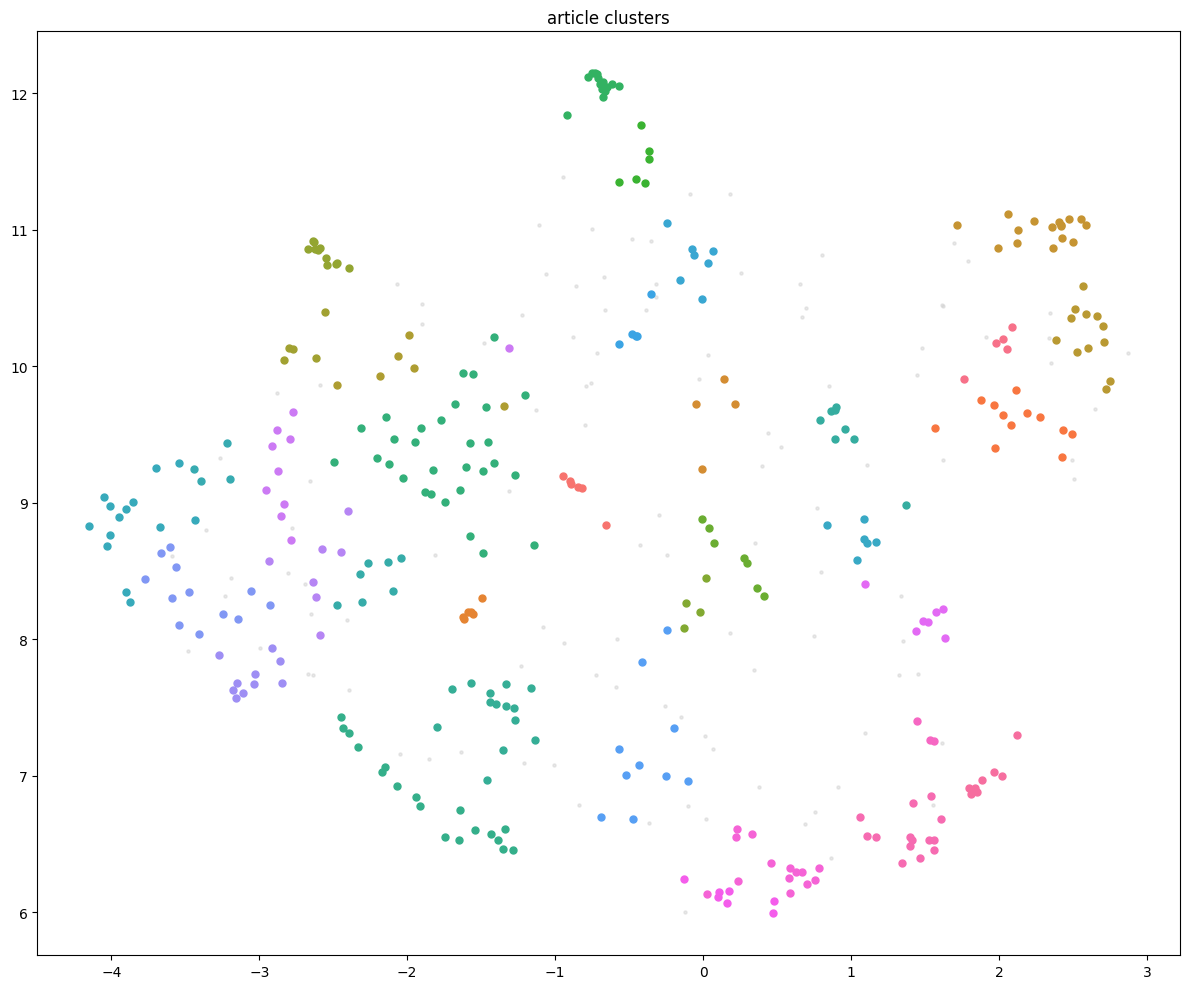

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# You can now retrain UMAP/HDBSCAN with the best params on the full data if needed
#best_params = study.best_trial.params
# Example:
# best_umap_n_neighbors = best_params['umap_n_neighbors']
# best_hdbscan_min_cluster_size = best_params['hdbscan_min_cluster_size']
# ... etc.


# use the optimized params
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=10,  # bumped up from 5
    min_dist=0.0,
    metric="cosine",
).fit_transform(all_embeddings)

# cluster with optimal params
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    min_samples=None,
    cluster_selection_epsilon=0.0,
    metric="euclidean",
    prediction_data=True,
)
cluster_labels = clusterer.fit_predict(umap_embeddings)

# add to dataframe same as before
articles_df["cluster"] = cluster_labels

# quick stats
print(f"found {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)} clusters")
print(f"noise points: {sum(cluster_labels == -1)}")

# 2d projection for visualization
umap_2d = umap.UMAP(n_components=2, metric="cosine").fit_transform(all_embeddings)

# plotting
plt.figure(figsize=(12, 10))
# plot noise points first (gray)
plt.scatter(
    umap_2d[cluster_labels == -1, 0],
    umap_2d[cluster_labels == -1, 1],
    c="lightgray",
    s=5,
    alpha=0.5,
    label="noise",
)

# plot actual clusters with random colors
unique_clusters = sorted(list(set(cluster_labels) - {-1}))
palette = sns.color_palette("husl", len(unique_clusters))

for i, cluster_id in enumerate(unique_clusters):
    plt.scatter(
        umap_2d[cluster_labels == cluster_id, 0],
        umap_2d[cluster_labels == cluster_id, 1],
        c=[palette[i]],
        s=25,
        label=f"cluster {cluster_id}",
    )

plt.title("article clusters")
plt.tight_layout()
plt.show()

# LLM Cluster review

In [6]:
clusters_ids = list(set(cluster_labels) - {-1})
clusters_with_articles = []
for cluster_id in clusters_ids:
    cluster_df = articles_df[articles_df['cluster'] == cluster_id]
    articles_ids = cluster_df['id'].tolist()
    clusters_with_articles.append({
        "cluster_id": cluster_id,
        "articles_ids": articles_ids
    })
# sort clusters by most articles to least articles
clusters_with_articles = sorted(clusters_with_articles, key=lambda x: len(x['articles_ids']), reverse=True)
print(len(clusters_with_articles))

35


In [7]:
for x in clusters_with_articles:
    print(f"\n\n# Cluster {x['cluster_id']}")
    for el in x['articles_ids']:
        article = next((e for e in events if e.id == el), None)
        if article is not None:
            print(f"- {article.title}")
            



# Cluster 14
- Trump nominates Dr Casey Means, influencer close to RFK Jr, for surgeon general
- 'You still don't get it': Congress grills three college presidents over antisemitism
- Jon Stewart Calls Out Donald Trump's Constitutional Duty Remark
- FTC Loses Appeal Against Microsoft's Activision Blizzard Acquisition
- Trump or Trans? Jasmine Crockett Chooses to Play Silly Game Instead of Protecting Women’s Sports
- Trump White House fires Biden-appointed vice chair of NTSB
- The heart of the internet
- A Most Sensitive Subject in the White House: Where Is Melania?
- Smokey Robinson’s Lawyer Slams ‘Vile’ and ‘False’ Sexual Assault Claims
- HHS Sec. RFK Jr. Announces NIH and CMS to Begin Joint Project on Resolving Autism, Chronic Diseases
- Watch: Scott Jennings Owns CNN Panel Who Lose It Over Trump's Authority on Transgenders in Military
- Crockett: GOP 'Running Scared' from Trump's Big Beautiful Bill
- Report: Mike DeWine Moves to Block State GOP from Endorsing Vivek Ramaswamy
- Tru

In [8]:
import base64
import os
from google.genai import types
from retry import retry
import json
from json_repair import repair_json
from pydantic import BaseModel, Field, model_validator
from typing import List, Literal, Optional
from src.llm import call_llm


class Story(BaseModel):
    title: str = Field(description="title of the story")
    importance: int = Field(
        ge=1,
        le=10,
        description="global significance (1=minor local event, 10=major global impact)",
    )
    articles: List[int] = Field(description="list of article ids in the story")


class StoryValidation(BaseModel):
    answer: Literal["single_story", "collection_of_stories", "pure_noise", "no_stories"]

    # optional fields that depend on the answer type
    title: Optional[str] = None
    importance: Optional[int] = Field(None, ge=1, le=10)
    outliers: List[int] = Field(default_factory=list)
    stories: Optional[List[Story]] = None

    @model_validator(mode="after")
    def validate_structure(self):
        if self.answer == "single_story":
            if self.title is None or self.importance is None:
                raise ValueError(
                    "'title' and 'importance' are required for 'single_story'"
                )
            if self.stories is not None:
                raise ValueError("'stories' should not be present for 'single_story'")

        elif self.answer == "collection_of_stories":
            if not self.stories:
                raise ValueError("'stories' is required for 'collection_of_stories'")
            if self.title is not None or self.importance is not None or self.outliers:
                raise ValueError(
                    "'title', 'importance', and 'outliers' should not be present for 'collection_of_stories'"
                )

        elif self.answer == "pure_noise" or self.answer == "no_stories":
            if (
                self.title is not None
                or self.importance is not None
                or self.outliers
                or self.stories is not None
            ):
                raise ValueError(
                    "no additional fields should be present for 'pure_noise'"
                )

        return self


@retry(tries=3, delay=2, backoff=2, jitter=2, max_delay=20)
def process_story(cluster):

    story_articles_ids = cluster["articles_ids"]

    story_article_md = ""
    for article_id in story_articles_ids:
        article = next((e for e in events if e.id == article_id), None)
        if article is None:
            continue
        story_article_md += f"- (#{article.id}) [{article.title}]({article.url})\n"
        # story_article_md += f"> {article.publishDate}\n\n"
        # story_article_md += f"```\n{article.content}\n```\n\n"
    story_article_md = story_article_md.strip()

    prompt = f"""
# Task
Determine if the following collection of news articles is:
1) A single story - A cohesive narrative where all articles relate to the same central event/situation and its direct consequences
2) A collection of stories - Distinct narratives that should be analyzed separately
3) Pure noise - Random articles with no meaningful pattern
4) No stories - Distinct narratives but none of them have more than 3 articles

# Important clarification
A "single story" can still have multiple aspects or angles. What matters is whether the articles collectively tell one broader narrative where understanding each part enhances understanding of the whole.

# Handling outliers
- For single stories: You can exclude true outliers in an "outliers" array
- For collections: Focus **only** on substantive stories (3+ articles). Ignore one-off articles or noise.

# Title guidelines
- Titles should be purely factual, descriptive and neutral
- Include necessary context (region, countries, institutions involved)
- No editorialization, opinion, or emotional language
- Format: "[Subject] [action/event] in/with [location/context]"

# Input data
Articles (format is (#id) [title](url)):
{story_article_md}

# Output format
Start by reasoning step by step. Consider:
- Central themes and events
- Temporal relationships (are events happening in the same timeframe?)
- Causal relationships (do events influence each other?)
- Whether splitting the narrative would lose important context

Return your final answer in JSON format:
```json
{{
    "answer": "single_story" | "collection_of_stories" | "pure_noise",
    // single_story_start: if answer is "single_story", include the following fields:
    "title": "title of the story",
    "importance": 1-10, // global significance (1=minor local event, 10=major global impact)
    "outliers": [] // array of article ids to exclude as unrelated
    // single_story_end
    // collection_of_stories_start: if answer is "collection_of_stories", include the following fields:
    "stories": [
        {{
            "title": "title of the story",
            "importance": 1-10, // global significance scale
            "articles": [] // list of article ids in the story (**only** include substantial stories with **3+ articles**)
        }},
        ...
    ]
    // collection_of_stories_end
}}
```

Example for a single story:
```json
{{
    "answer": "single_story",
    "title": "The Great Fire of London",
    "importance": 8,
    "outliers": [123, 456] // article ids to exclude as unrelated
}}
```

Example for a collection of stories:
```json
{{
    "answer": "collection_of_stories",
    "stories": [
        {{
            "title": "The Great Fire of London",
            "importance": 8,
            "articles": [123, 456] // article ids in the story
        }},
        ...
    ]
}}
```

Example for pure noise:
```json
{{
    "answer": "pure_noise"
}}
```

Example for a distinct narratives with no stories that contain more than 3+ articles:
```json
{{
    "answer": "no_stories",
}}
```

Note:
- Always include articles IDs (outliers, articles, etc...) as integers, not strings and never include the # symbol.
""".strip()

    answer, usage = call_llm(
        model="gemini-2.0-flash",
        #model="gemini-2.5-pro-preview-03-25",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )

    try:
        assert "```json" in answer
        answer = answer.split("```json")[1]
        if answer.endswith("```"):
            answer = answer[:-3]
        answer = answer.strip()
        answer = repair_json(answer)
        answer = json.loads(answer)
        parsed = StoryValidation(**answer)
    except Exception as e:
        print(f"Error parsing story: {e}")
        print(cluster)
        print(answer)
        raise e

    return (parsed, usage)

Loading .env file from: C:\Users\phili\meridian\.env
Google API Key configured successfully.


In [9]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Submit all tasks and process in parallel
with ThreadPoolExecutor() as executor:
    # Submit all tasks and get future objects
    futures = [
        executor.submit(process_story, story) for story in clusters_with_articles
    ]

    # Use tqdm to show progress while getting results
    cleaned_clusters_raw = list(
        tqdm(
            (future.result() for future in futures),
            total=len(futures),
            desc="Processing stories",
        )
    )

Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': '# Task\nDetermine if the following collection of news articles is:\n1) A single story - A cohesive narrative where all articles relate to the same central event/situation and its direct consequences\n2) A collection of stories - Distinct narratives that should be analyzed separately\n3) Pure noise - Random articles with no meaningful pattern\n4) No stories - Distinct narratives but none of them have more than 3 articles\n\n# Important clarification\nA "single story" can still have multiple aspects or angles. What matters is whether the articles collectively tell one broader narrative where understanding each part enhances understanding of the whole.\n\n# Handling outliers\n- For single stories: You can exclude true outliers in an "outliers" array\n- For collections: Focus **only** on substantive stories (3+ articles). Ignore one-off articles or noise.\

Processing stories:   0%|                                                                       | 0/35 [00:00<?, ?it/s]

LLM call successful.
Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': '# Task\nDetermine if the following collection of news articles is:\n1) A single story - A cohesive narrative where all articles relate to the same central event/situation and its direct consequences\n2) A collection of stories - Distinct narratives that should be analyzed separately\n3) Pure noise - Random articles with no meaningful pattern\n4) No stories - Distinct narratives but none of them have more than 3 articles\n\n# Important clarification\nA "single story" can still have multiple aspects or angles. What matters is whether the articles collectively tell one broader narrative where understanding each part enhances understanding of the whole.\n\n# Handling outliers\n- For single stories: You can exclude true outliers in an "outliers" array\n- For collections: Focus **only** on substantive stories (3+ articles). Ignore one-of

Processing stories:   3%|█▊                                                             | 1/35 [00:04<02:21,  4.17s/it]

LLM call successful.
Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': '# Task\nDetermine if the following collection of news articles is:\n1) A single story - A cohesive narrative where all articles relate to the same central event/situation and its direct consequences\n2) A collection of stories - Distinct narratives that should be analyzed separately\n3) Pure noise - Random articles with no meaningful pattern\n4) No stories - Distinct narratives but none of them have more than 3 articles\n\n# Important clarification\nA "single story" can still have multiple aspects or angles. What matters is whether the articles collectively tell one broader narrative where understanding each part enhances understanding of the whole.\n\n# Handling outliers\n- For single stories: You can exclude true outliers in an "outliers" array\n- For collections: Focus **only** on substantive stories (3+ articles). Ignore one-of

Processing stories:  31%|███████████████████▍                                          | 11/35 [00:04<00:08,  3.00it/s]

LLM call successful.
LLM call successful.
LLM call successful.
LLM call successful.
LLM call successful.
LLM call successful.
LLM call successful.
LLM call successful.


Processing stories:  60%|█████████████████████████████████████▏                        | 21/35 [00:05<00:02,  5.86it/s]

LLM call successful.
LLM call successful.
LLM call successful.
LLM call successful.


Processing stories:  69%|██████████████████████████████████████████▌                   | 24/35 [00:05<00:01,  6.86it/s]

LLM call successful.


Processing stories: 100%|██████████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  5.96it/s]

LLM call successful.
LLM call successful.


In [10]:

cleaned_clusters = []

class Story(BaseModel):
    id: int = Field(description="id of the story")
    title: str = Field(description="title of the story")
    importance: int = Field(
        ge=1,
        le=10,
        description="global significance (1=minor local event, 10=major global impact)",
    )
    articles: List[int] = Field(description="list of article ids in the story")



for i in range(len(clusters_with_articles)):
    base = clusters_with_articles[i]
    res = cleaned_clusters_raw[i][0]

    if res.answer == "single_story":
        
        article_ids = base["articles_ids"]
        # filter out outliers
        article_ids = [x for x in article_ids if x not in res.outliers]
        
        cleaned_clusters.append(
            Story(
                id=len(cleaned_clusters),
                title=res.title,
                importance=res.importance,
                articles=article_ids,
            )
        )
    elif res.answer == "collection_of_stories":
        for story in res.stories:
            cleaned_clusters.append(Story(
                id=len(cleaned_clusters),
                title=story.title,
                importance=story.importance,
                articles=story.articles,
            ))

# sort by importance
cleaned_clusters = sorted(cleaned_clusters, key=lambda x: x.importance, reverse=True)

lowest_importance = cleaned_clusters[0].importance
highest_importance = cleaned_clusters[-1].importance

print(f"lowest importance: {lowest_importance}")
print(f"highest importance: {highest_importance}")

print(len(cleaned_clusters))

lowest importance: 9
highest importance: 2
26


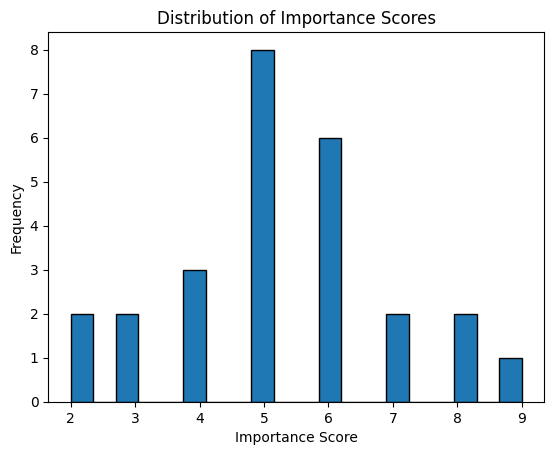

7
19


In [11]:
# plot distribution of importance
importance_values = [cluster.importance for cluster in cleaned_clusters]
plt.hist(importance_values, bins=20, edgecolor='black')
plt.title('Distribution of Importance Scores')
plt.xlabel('Importance Score')
plt.ylabel('Frequency')
plt.show()

# show clusters with importance < 5
low_importance_clusters = [cluster for cluster in cleaned_clusters if cluster.importance < 5]
high_importance_clusters = [cluster for cluster in cleaned_clusters if cluster.importance >= 5]
print(len(low_importance_clusters))
print(len(high_importance_clusters))

In [12]:
all_cleaned_clusters = ""
for x in cleaned_clusters:
    # print(f"# ID: {x.id} - {x.title}")
    all_cleaned_clusters += f"# ID: {x.id} - {x.title}\n"
    for article_id in x.articles:
        article = article = next((e for e in events if e.id == article_id), None)
        if article is not None:
            # print(f"  - {article.title}")
            all_cleaned_clusters += f"  - {article.title}\n"
        # else:
        # print(f" MISSED article_id: {article_id}")
        # print(f"- {article.title}")
    # print("\n")
    all_cleaned_clusters += "\n"
all_cleaned_clusters = all_cleaned_clusters.strip()


cluser_reconciliation = (
    """
You are an expert news analyst AI tasked with refining a set of automatically generated news clusters. You will receive a list of clusters, each identified by an ID, a title, and a list of associated article titles.

Your primary goal is to identify clusters that should be **merged** because they represent different facets or developments of the *same core story or event*, rather than distinct narratives. Use the following rule of thumb: **"If analyzing the articles in Cluster A would feel incomplete or artificially separated from the articles in Cluster B because they fundamentally describe the same specific event, ongoing situation, or central topic, they should be merged."**

Distinguish this from clusters that are merely *related* thematically but cover different specific events, angles, or sub-topics that *can* stand alone as separate stories, even if they might be linked later in analysis. For example:

*   **Merge Candidate Example:** Cluster 1 covers the initial report of a factory fire. Cluster 2 covers the emergency response and evacuation related to *that same fire*. Cluster 3 covers the investigation into the cause of *that same fire*. These are facets of the *same core story* (the factory fire event) and should likely be merged.
*   **Keep Separate Example:** Cluster 1 covers a new trade agreement signed between Country X and Country Y. Cluster 2 covers protests *within* Country X about the economic impact of *that trade agreement*. While related, the signing event and the domestic protest are distinct stories/angles that could be analyzed separately. Cluster 3 covers a *different* trade dispute Country X has with Country Z – clearly a separate story.

Your secondary goal is to identify clusters that should be **filtered out** before further processing. **Filtering should be used sparingly**, primarily to remove noise and maintain data quality, not to judge the importance of a story. The aim is to retain a record of all distinct, coherent events, even routine or smaller ones. Filter *only* if a cluster meets one of these specific criteria:
*   **Very Low Article Count:** Contains **fewer than 3 articles**, indicating it likely doesn't represent a sufficiently developed or distinct event captured in the data.
*   **Incoherent or Noise:** The articles within the cluster do not form a coherent topic, or the cluster appears to be noise/junk data.
*   **Strict Duplicate:** The cluster covers the *exact same specific event* as another cluster, often with significant overlap in articles, making it redundant. (Do not filter merely *related* clusters).
*   **Clearly Irrelevant:** The content is demonstrably not related to news events (e.g., advertisements, site navigation links clustered together).

**Input Format:**

The input will be structured text as follows:

```
# ID: [Cluster ID 1] - [Cluster Title 1]
  - [Article Title 1a]
  - [Article Title 1b]
  ...

# ID: [Cluster ID 2] - [Cluster Title 2]
  - [Article Title 2a]
  - [Article Title 2b]
  ...

[... more clusters ...]
```
*(Note: Cluster IDs in the input might be strings or numbers, please preserve them as strings in the JSON output).*

**Output Requirements:**

Your output **MUST** be a single, valid JSON object containing two keys: `merges` and `filters`.

1.  **`merges`**: An array of objects. Each object represents a single merge operation and must contain:
    *   `cluster_ids_to_merge`: An array of strings, listing the original Cluster IDs that should be merged together.
    *   `reason`: A brief string explaining *why* these clusters belong together based on the "same core story" principle.
    *   `suggested_new_title`: A string proposing a suitable title for the newly merged cluster.

2.  **`filters`**: An array of objects. Each object represents a single cluster recommended for filtering and must contain:
    *   `cluster_id_to_filter`: A string representing the original Cluster ID to be filtered out.
    *   `reason`: A brief string explaining the justification, strictly based on the filtering criteria above (e.g., "Fewer than 3 articles", "Incoherent topic/Noise", "Duplicate of Cluster X", "Irrelevant content").

**Example JSON Output Structure:**

```json
{
  "merges": [
    {
      "cluster_ids_to_merge": ["C005", "C012", "C023"],
      "reason": "Covers different aspects (initial report, response, investigation) of the same factory fire event.",
      "suggested_new_title": "Major Factory Fire Incident and Investigation (Cityville)"
    },
    {
      "cluster_ids_to_merge": ["C008", "C015"],
      "reason": "Both clusters detail phases of the same election recount process.",
      "suggested_new_title": "State Election Recount Process and Results"
    }
  ],
  "filters": [
    {
      "cluster_id_to_filter": "C019",
      "reason": "Fewer than 3 articles."
    },
    {
      "cluster_id_to_filter": "C028",
      "reason": "Duplicate of Cluster C005."
    },
    {
      "cluster_id_to_filter": "C031",
      "reason": "Incoherent topic/Noise."
    }
  ]
}
```

Analyze the provided cluster list carefully based on these instructions and return ONLY the JSON object. Do not include any introductory text or explanations outside the JSON structure itself.
""".strip()
    + "\n\n"
    + all_cleaned_clusters
)

cluster_reconciliation_response = call_llm(
    model="gemini-2.0-flash",
    messages=[{"role": "user", "content": cluser_reconciliation}],
    temperature=0,
)

Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': 'You are an expert news analyst AI tasked with refining a set of automatically generated news clusters. You will receive a list of clusters, each identified by an ID, a title, and a list of associated article titles.\n\nYour primary goal is to identify clusters that should be **merged** because they represent different facets or developments of the *same core story or event*, rather than distinct narratives. Use the following rule of thumb: **"If analyzing the articles in Cluster A would feel incomplete or artificially separated from the articles in Cluster B because they fundamentally describe the same specific event, ongoing situation, or central topic, they should be merged."**\n\nDistinguish this from clusters that are merely *related* thematically but cover different specific events, angles, or sub-topics that *can* stand alone as separate stories,

In [13]:
cluster_reconciliation_json = cluster_reconciliation_response[0]
cluster_reconciliation_json = cluster_reconciliation_json.split("```json")[1]
cluster_reconciliation_json = cluster_reconciliation_json.strip()
cluster_reconciliation_json = cluster_reconciliation_json.split("```")[0]
cluster_reconciliation_json = json.loads(cluster_reconciliation_json)


cluster_reconciliation_json


{'merges': [{'cluster_ids_to_merge': ['23', '5'],
   'reason': "Both clusters relate to the Israel-Gaza conflict in October 2023. Cluster 23 focuses on the conflict's escalation and international reactions, while Cluster 5 details a specific terror plot targeting the Israeli embassy in London. These are facets of the same core event.",
   'suggested_new_title': 'Israel-Gaza Conflict Escalation, International Reactions, and Related Security Concerns (October 2023)'},
  {'cluster_ids_to_merge': ['9', '10'],
   'reason': 'Both clusters cover Europa League matches involving UK teams (Manchester United and Tottenham) against Athletic Bilbao and Bodo/Glimt respectively. They represent related sporting events within the same competition.',
   'suggested_new_title': 'Europa League Matches: Manchester United vs Athletic Bilbao & Bodo/Glimt vs Tottenham'}],
 'filters': [{'cluster_id_to_filter': '20',
   'reason': 'Fewer than 3 articles.'},
  {'cluster_id_to_filter': '1', 'reason': 'Fewer than 3 

In [14]:
from typing import List, Dict, Any

def apply_story_modifications(original_stories: List[Story], instructions: Dict[str, Any]) -> List[Story]:
    """
    Applies merge and filter instructions to a list of Story objects.

    Args:
        original_stories: A list of Pydantic Story objects.
        instructions: A dictionary loaded from the JSON instructions,
                      containing 'merges' and 'filters' lists.
                      Cluster IDs in instructions should match Story IDs (as strings).

    Returns:
        A list of Story objects representing the modified ('super cleaned')
        stories. Merged stories will have a new title, combined articles, and
        potentially updated importance. Filtered stories will be removed.
        Unaffected stories are passed through.
    """

    # 1. Identify story IDs to filter and those involved in merges
    #    Instructions use string IDs, so convert Story IDs to strings for comparison
    story_ids_to_filter_str = set(
        item['cluster_id_to_filter'] for item in instructions.get('filters', [])
    )

    all_merged_ids_str = set()
    merge_instructions = instructions.get('merges', [])
    for merge_op in merge_instructions:
        # IDs in instructions are strings
        ids_in_this_merge_str = merge_op.get('cluster_ids_to_merge', [])
        all_merged_ids_str.update(ids_in_this_merge_str)

    # 2. Create a dictionary for quick lookup of original stories by ID (as strings)
    #    Only include stories that are NOT being filtered out initially.
    stories_by_id_str: Dict[str, Story] = {
        str(story.id): story
        for story in original_stories
        if str(story.id) not in story_ids_to_filter_str
    }

    super_cleaned_stories: List[Story] = []

    # 3. Process Merges
    processed_for_merge_str: Set[str] = set() # Keep track of string IDs already handled
    for merge_op in merge_instructions:
        # IDs in instructions are strings
        ids_to_merge_str = merge_op.get('cluster_ids_to_merge', [])
        suggested_title = merge_op.get('suggested_new_title', "Merged Story")

        # Filter out any IDs in this specific merge operation that were
        # either already filtered globally or don't exist in our lookup
        valid_ids_for_this_merge_str = [
            sid for sid in ids_to_merge_str
            if sid in stories_by_id_str and sid not in processed_for_merge_str
        ]

        if not valid_ids_for_this_merge_str:
            continue # Skip if no valid stories left for this merge

        combined_articles: Set[int] = set()
        max_importance: int = 0 # Initialize importance

        for story_id_str in valid_ids_for_this_merge_str:
            source_story = stories_by_id_str[story_id_str]
            articles_set = set(source_story.articles) # Use articles directly
            combined_articles.update(articles_set)
            # Update importance to the maximum seen so far
            max_importance = max(max_importance, source_story.importance)
            processed_for_merge_str.add(story_id_str) # Mark as handled

        if not combined_articles:
            continue # Skip if merging results in no articles

        # Create the new merged Story object
        # Use the ID (as int) of the first valid story in the merge list
        new_story_id = int(valid_ids_for_this_merge_str[0])
        # Ensure importance is at least 1 if max_importance remained 0 (edge case)
        final_importance = max(1, max_importance)

        try:
            merged_story = Story(
                id=new_story_id,
                title=suggested_title,
                importance=final_importance,
                articles=sorted(list(combined_articles)) # Store as sorted list
            )
            super_cleaned_stories.append(merged_story)
        except ValidationError as e:
            print(f"Validation Error creating merged story for IDs {valid_ids_for_this_merge_str}: {e}")
            # Decide how to handle validation errors, e.g., skip or log


    # 4. Add stories that were neither filtered nor merged
    for story_id_str, story_data in stories_by_id_str.items():
        if story_id_str not in processed_for_merge_str:
             # Ensure articles are sorted (already a list in Story model)
            story_data.articles.sort()
            super_cleaned_stories.append(story_data)

    return super_cleaned_stories

super_cleaned_stories = apply_story_modifications(
        cleaned_clusters,
        cluster_reconciliation_json
    )

## LLM Analyze & enrich cluster

In [15]:
import base64
import os
import tiktoken

enc = tiktoken.get_encoding("o200k_base")


@retry(
    tries=4, delay=2, backoff=2, jitter=1, max_delay=20
)  # max_delay=180 means never wait more than 3 mins
def final_process_story(title: str, articles_ids: list[int]):

    story_article_md = ""
    full_articles = []
    for article_id in articles_ids:
        article = next((e for e in events if e.id == article_id), None)
        if article is None:
            print(f"Article {article_id} not found")
            continue
        else:
            full_articles.append(article)

    # sort by publish date (from latest to oldest)
    # full_articles = sorted(full_articles, key=lambda x: x["publishDate"], reverse=True)
    for article in full_articles:
        story_article_md += f"## [{article.title}]({article.url}) (#{article.id})\n\n"
        story_article_md += f"> {article.publishDate}\n\n"
        story_article_md += f"```\n{article.content}\n```\n\n"

    story_article_md = story_article_md.strip()

    pre_prompt = """
You are a highly skilled intelligence analyst working for a prestigious agency. Your task is to analyze a cluster of related news articles and extract structured information for an executive intelligence report. The quality, accuracy, precision, and **consistency** of your analysis are crucial, as this report will directly inform a high-level daily brief and potentially decision-making.

First, assess if the articles provided contain sufficient content for analysis:

Here is the cluster of related news articles you need to analyze:

<articles>
""".strip()

    post_prompt = """
</articles>

BEGIN ARTICLE QUALITY CHECK:
Before proceeding with analysis, verify if the articles contain sufficient information:
1. Check if articles appear empty or contain minimal text (fewer than ~50 words each)
2. Check for paywall indicators ("subscribe to continue", "premium content", etc.)
3. Check if articles only contain headlines/URLs but no actual content
4. Check if articles appear truncated or cut off mid-sentence

If ANY of these conditions are true, return ONLY this JSON structure inside <final_json> tags:
<final_json>
{
    "status": "incomplete",
    "reason": "Brief explanation of why analysis couldn't be completed (empty articles, paywalled content, etc.)",
    "availableInfo": "Brief summary of any information that was available"
}
</final_json>

ONLY IF the articles contain sufficient information for analysis, proceed with the full analysis below:

Your goal is to extract and synthesize information from these articles into a structured format suitable for generating a daily intelligence brief.

Before addressing the main categories, conduct a preliminary analysis:
a) List key themes across all articles
b) Note any recurring names, places, or events
c) Identify potential biases or conflicting information
It's okay for this section to be quite long as it helps structure your thinking.

Then, after your preliminary analysis, present your final analysis in a structured JSON format inside <final_json> tags. This must be valid, parseable JSON that follows this **exact refined structure**:

**Detailed Instructions for JSON Fields:**
*   **`status`**: 'complete' or 'incomplete'
*   **`title`**: Terse, neutral title of the story
*   **`executiveSummary`**: Provide a 2-4 sentence concise summary highlighting the most critical developments, key conflicts, and overall assessment from the articles. This should be suitable for a quick read in a daily brief.
*   **`storyStatus`**: Assess the current state of the story's development based *only* on the information in the articles. Use one of: 'Developing', 'Escalating', 'De-escalating', 'Concluding', 'Static'.
*   **`timeline`**: List key events in chronological order.
    *   `description`: Keep descriptions brief and factual.
    *   `importance`: Assess the event's importance to understanding the overall narrative (High/Medium/Low). High importance implies the event is central to the story's development or outcome.
*   **`signalStrength`**: Assess the overall reliability of the reporting *in this cluster*.
    *   `assessment`: Use a qualitative term: 'Very High', 'High', 'Moderate', 'Low', 'Very Low'.
    *   `reasoning`: Justify the assessment based on source corroboration (how many sources report the same core facts?), source quality/reliability (mix of reputable vs. biased sources?), presence of official statements, and degree of conflicting information on core facts.
*   **`undisputedKeyFacts`**: List core factual points that are corroborated across multiple, generally reliable sources within the cluster. Avoid claims made only by highly biased sources unless corroborated.
*   **`keyEntities`**: Identify the main actors.
    *   `list`: Provide basic identification and their role/involvement.
    *   `perspectives.statedPositions`: Focus *only* on the goals, viewpoints, or justifications explicitly stated or clearly implied by the entity *as reported in the articles*. Avoid listing conflicting claims here (that goes in `contradictions`).
*   **`keySources`**: Analyze the provided news sources.
    *   `provided_articles_sources.reliabilityAssessment`: Assess the source's general reliability based on reputation, known biases (political, state affiliation, ideological), and fact-checking standards. Use terms like 'High Reliability', 'Moderate Reliability', 'Low Reliability', 'State-Affiliated/Propaganda Outlet'. Be specific about the *type* of bias.
    *   `provided_articles_sources.framing`: Describe the narrative angle or style used by the source (e.g., 'Emphasizes security threat', 'Focuses on human rights angle', 'Uses neutral language', 'Uses loaded/emotional language', 'Presents government narrative uncritically').
    *   `contradictions`: Detail specific points of disagreement *between sources* or *between entities as reported by sources*.
        *   `issue`: Clearly state what is being contested.
        *   `conflictingClaims`: List the different versions, specifying the `source` reporting it, the `claim` itself, and optionally the `entityClaimed` if the source attributes the claim to a specific entity. Critically evaluate claims originating solely from low-reliability/propaganda sources.
*   **`context`**: List essential background information *mentioned or clearly implied in the articles* needed to understand the story.
*   **`informationGaps`**: Identify crucial pieces of information *missing* from the articles that would be needed for a complete understanding.
*   **`significance`**: Assess the overall importance of the reported events.
    *   `assessment`: Use a qualitative term: 'Critical', 'High', 'Moderate', 'Low'.
    *   `reasoning`: Explain *why* this story matters. Consider immediate impact, potential future developments, strategic implications, precedent setting, regional/global relevance.
    *   `score`: An integer between 0 (lowest importance story) and 10 (most critical story)

**Refined JSON Structure to Follow:**

```json
{
    "status": "complete",
    "title": "string",
    "executiveSummary": "string",
    "storyStatus": "string",
    "timeline": [
        {
            "date": "YYYY-MM-DD or approximate",
            "description": "brief event description",
            "importance": "string: High/Medium/Low"
        }
    ],
    "signalStrength": {
        "assessment": "string: Very High/High/Moderate/Low/Very Low",
        "reasoning": "string"
    },
    "undisputedKeyFacts": [
        "string"
    ],
    "keyEntities": {
        "list": [
            {
                "name": "entity name",
                "type": "type of entity",
                "description": "brief description",
                "involvement": "why/how involved?"
            }
        ],
        "perspectives": [
            {
                "entity": "entity name",
                "statedPositions": [
                    "string"
                ]
            }
        ]
    },
    "keySources": {
        "provided_articles_sources": [
            {
                "name": "source entity name",
                "articles": [], // int array of IDs
                "reliabilityAssessment": "string",
                "framing": [
                    "string"
                ]
            }
        ],
        "contradictions": [
            {
                "issue": "string",
                "conflictingClaims": [
                    {
                        "source": "media source name",
                        "entityClaimed": "entity name (optional)",
                        "claim": "string"
                    }
                ]
            }
        ]
    },
    "context": [
        "string"
    ],
    "informationGaps": [
        "string"
    ],
    "significance": {
        "assessment": "string: Critical/High/Moderate/Low",
        "reasoning": "string",
        "score": 0
    }
}
```

**CRITICAL Quality & Consistency Requirements:**

*   **Thoroughness:** Ensure all fields, especially descriptions, reasoning, context, and summaries, are detailed and specific. Avoid superficial or overly brief entries. Your analysis must reflect deep engagement with the provided texts.
*   **Grounding:** Base your entire analysis **SOLELY** on the content within the provided `<articles>` tags. Do not introduce outside information, assumptions, or knowledge.
*   **No Brevity Over Clarity:** Do **NOT** provide one-sentence descriptions or reasoning where detailed analysis is required by the field definition.
*   **Scrutinize Sources:** Pay close attention to the reliability assessment of sources when evaluating claims, especially in the `contradictions` section. Note when a claim originates primarily or solely from a low-reliability source.
*   **Validity:** Your JSON inside `<final_json></final_json>` tags MUST be 100% fully valid with no trailing commas, properly quoted strings and escaped characters where needed, and follow the exact refined structure provided. Ensure keys are in the specified order. Your entire JSON output should be directly extractable and parseable without human intervention.

Return your complete response, including your preliminary analysis/thinking in any format you prefer, followed by the **full** valid JSON inside `<final_json></final_json>` tags.
""".strip()

    # enc.decode(enc.encode("hello world"))
    tokens = enc.encode(story_article_md)

    # only keep the first million tokens
    tokens = tokens[:850_000]
    story_article_md = enc.decode(tokens)

    prompt = pre_prompt + "\n\n" + story_article_md + "\n\n" + post_prompt
    # print(prompt)

    answer, usage = call_llm(
        model="gemini-2.0-flash",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )

    text = answer

    if "```json" in text:
        text = text.split("```json")[1]
        text = text.strip()

    if "<final_json>" in text:
        text = text.split("<final_json>")[1]
        text = text.strip()

    if "</final_json>" in text:
        text = text.split("</final_json>")[0]
        text = text.strip()

    if text.endswith("```"):
        text = text.replace("```", "")
        text = text.strip()

    # text = repair_json(text)

    # assert "significance" in text

    return answer, usage

In [16]:
from concurrent.futures import ThreadPoolExecutor, as_completed

cluster_analysis = []

# helper function to process a single cluster
def process_cluster(cluster):
    title = cluster.title
    articles_ids = cluster.articles
    return final_process_story(title=title, articles_ids=articles_ids)

# process clusters in parallel using a thread pool
with ThreadPoolExecutor() as executor:
    # submit all tasks and store futures
    futures = [executor.submit(process_cluster, cluster) 
              for cluster in super_cleaned_stories]
    
    # collect results as they complete using tqdm for progress
    for future in tqdm(as_completed(futures), total=len(futures)):
        cluster_analysis.append(future.result())

Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': 'You are a highly skilled intelligence analyst working for a prestigious agency. Your task is to analyze a cluster of related news articles and extract structured information for an executive intelligence report. The quality, accuracy, precision, and **consistency** of your analysis are crucial, as this report will directly inform a high-level daily brief and potentially decision-making.\n\nFirst, assess if the articles provided contain sufficient content for analysis:\n\nHere is the cluster of related news articles you need to analyze:\n\n<articles>\n\n## [Man Utd vs Athletic Club: Prediction, kick-off time, team news and TV](https://www.standard.co.uk/sport/football/man-utd-vs-athletic-club-prediction-kick-off-time-latest-team-news-tv-live-stream-h2h-results-odds-europa-league-2025-preview-today-b1226160.html) (#52762)\n\n> 2025-05-08 06:19:38+00:00\n

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': 'You are a highly skilled intelligence analyst working for a prestigious agency. Your task is to analyze a cluster of related news articles and extract structured information for an executive intelligence report. The quality, accuracy, precision, and **consistency** of your analysis are crucial, as this report will directly inform a high-level daily brief and potentially decision-making.\n\nFirst, assess if the articles provided contain sufficient content for analysis:\n\nHere is the cluster of related news articles you need to analyze:\n\n<articles>\n\n## [Destiny 2: The Edge of Fate Expansion Launches July 15, Star Wars-Inspired Renegades Expansion Announced](https://www.vgchartz.com/article/464630/destiny-2-the-edge-of-fate-expansion-launches-july-15-star-wars-inspired-renegades-expansion-announced/) (#50073)\n\n> 2025-05-07 02:57:43+00:00\n\n```\nby

  6%|████▌                                                                              | 1/18 [00:12<03:29, 12.34s/it]

LLM call successful.
Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': 'You are a highly skilled intelligence analyst working for a prestigious agency. Your task is to analyze a cluster of related news articles and extract structured information for an executive intelligence report. The quality, accuracy, precision, and **consistency** of your analysis are crucial, as this report will directly inform a high-level daily brief and potentially decision-making.\n\nFirst, assess if the articles provided contain sufficient content for analysis:\n\nHere is the cluster of related news articles you need to analyze:\n\n<articles>\n\n## [Race Across The World fans demand answers after stars were \'separated as children\'](https://metro.co.uk/2025/05/07/race-across-world-stars-reveal-weird-mystery-separated-children-23045554/) (#53194)\n\n> 2025-05-07 22:25:09+00:00\n\n```\nRace Across The World brothers Brian and

 11%|█████████▏                                                                         | 2/18 [00:12<01:26,  5.44s/it]

LLM call successful.
Attempting to call model: gemini-2.0-flash with temperature: 0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': 'You are a highly skilled intelligence analyst working for a prestigious agency. Your task is to analyze a cluster of related news articles and extract structured information for an executive intelligence report. The quality, accuracy, precision, and **consistency** of your analysis are crucial, as this report will directly inform a high-level daily brief and potentially decision-making.\n\nFirst, assess if the articles provided contain sufficient content for analysis:\n\nHere is the cluster of related news articles you need to analyze:\n\n<articles>\n\n## [Man accused of harassing Jennifer Aniston for two years before crashing car through gates of her home](https://news.sky.com/story/man-accused-of-harassing-jennifer-aniston-for-two-years-before-crashing-car-through-gates-of-her-home-13363626) (#46917)\n\n> 2025-05-08 01:16:00+00:0

 28%|███████████████████████                                                            | 5/18 [00:16<00:27,  2.13s/it]

LLM call successful.
LLM call successful.


 33%|███████████████████████████▋                                                       | 6/18 [00:16<00:18,  1.54s/it]

LLM call successful.
LLM call successful.


 44%|████████████████████████████████████▉                                              | 8/18 [00:17<00:11,  1.17s/it]

LLM call successful.


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:18<00:09,  1.08s/it]

LLM call successful.


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:18<00:06,  1.17it/s]

LLM call successful.


 61%|██████████████████████████████████████████████████                                | 11/18 [00:19<00:05,  1.31it/s]

LLM call successful.


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:20<00:04,  1.35it/s]

LLM call successful.
LLM call successful.


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:20<00:01,  2.04it/s]

LLM call successful.
LLM call successful.


 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [00:20<00:00,  2.82it/s]

LLM call successful.


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:23<00:00,  1.03it/s]

LLM call successful.


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:27<00:00,  1.50s/it]

LLM call successful.


In [17]:
from json_repair import repair_json

final_json_to_process = []

for i in range(len(cluster_analysis)):
    cluster = cluster_analysis[i]
    text = cluster[0]

    if "```json" in text:
        text = text.split("```json")[1]
        text = text.strip()

    if "<final_json>" in text:
        text = text.split("<final_json>")[1]
        text = text.strip()

    if "</final_json>" in text:
        text = text.split("</final_json>")[0]
        text = text.strip()

    if text.endswith("```"):
        text = text.replace("```", "")
        text = text.strip()

    text = repair_json(text)

    try:
        text_parsed = json.loads(text)

        if text_parsed["status"] == "incomplete":
            continue
        else:
            final_json_to_process.append(text_parsed)
    except:
        print(text)
        raise Exception("no final json")
    
# "assessment": "string: Critical/High/Moderate/Low",
# sort assessment by "Critical" first, then "High", then "Moderate", then "Low"

final_json_to_process = sorted(
    final_json_to_process, key=lambda x: x["significance"]["score"], reverse=True
)

# final_json_to_process = sorted(
#     final_json_to_process, key=lambda x: x["significance"]["score"], reverse=True
# )

print(len(cluster_analysis))
print(len(final_json_to_process))

18
18


In [18]:
article_ids_used = []

for el in final_json_to_process:
    if "keySources" not in el:
        print("No keySources")
        continue
        
    for source in el['keySources']['provided_articles_sources']:
        for article_id in source['articles']:
            article_ids_used.append(article_id)

article_ids_used = list(set(article_ids_used))
used_events = []
used_sources = []
for article_id in article_ids_used:
    found_event = next((event for event in events if event.id == article_id), None)
    if found_event:
        link = found_event.url
        # print(link)
        
        # get just domain name 
        domain = link.split("//")[1].split("/")[0]
        if domain not in used_sources:
            used_sources.append(domain)
        
        used_events.append(found_event)

In [19]:
for clus in final_json_to_process:
    print(f"\n\n# {clus['title']}")
    
    print(f"\n**Status:** {clus['status']} | **Signal Strength:** {clus['signalStrength']['assessment']} | **Significance:** {clus['significance']['assessment']} ({clus['significance']['score']})")
    print(f"\n> {clus['executiveSummary']}\n\n---")
    # table with (status, signal strength, significance)
    



# Papal Conclave Continues: Cardinals Fail to Elect Pope on Second Day

**Status:** complete | **Signal Strength:** High | **Significance:** High (8)

> The Papal Conclave continues into its second day as cardinals have yet to elect a successor to Pope Francis, signaled by black smoke emerging from the Sistine Chapel. The 133 cardinals, deeply divided between progressive and conservative factions, are participating in multiple rounds of voting daily until a two-thirds majority is reached. The election is seen as a referendum on Francis's legacy, with the next pope facing challenges including strained finances and the sexual abuse crisis.

---


# Extreme Weather Events Intensify, Threatening Vulnerable Populations and Food Security

**Status:** complete | **Signal Strength:** Moderate | **Significance:** High (8)

> A cluster of articles highlights the increasing frequency and intensity of extreme weather events globally, from heavy rainfall and flooding in the US South to drought co

# Brief generation

## Generate outline

In [20]:
import os
import requests

# with headers
latest_report = requests.get(
        "http://localhost:8787/reports/last-report",
        headers={
            "Authorization": f"Bearer {os.environ.get('MERIDIAN_SECRET_KEY')}"
        }
    )
latest_report = latest_report.json()
latest_report_text = f"""
## Previous Day's Coverage Context ({latest_report['createdAt'].split('T')[0]})

### {latest_report['title']}

{latest_report['tldr']}
"""
print(latest_report)

# latest_report = """
# ## Previous Day's Coverage Context (2025-03-30)

# ### trump tariffs, south sudan crisis, turkey crackdown & dei clash

# ['Trump Tariffs: Global Trade | Escalating | Trump, UK, EU, Canada, Auto Industry | New tariffs loom, retaliation expected', 'South Sudan: Political Crisis | Escalating | Riek Machar, SPLM-IO, UN, Kiir, South Sudan | Machar arrest sparks civil war fears', 'Turkey: Crackdown on Dissent | Escalating | Erdogan, Imamoglu, CHP, Turkey, Istanbul | Protests grow, government crackdown intensifies', 'US: DEI Culture War | Escalating | Trump Administration, France, US Embassy, DEI, Companies | US demands French firms ditch DEI programs', 'US Campuses: Protest Crackdown | Escalating | ICE, Columbia, Tufts, Students, Pro-Palestinian Activists | Deportation threats, surveillance target pro-Palestinian students', 'Syria: Interim Government | Developing | Al-Sharaa, HTS, Kabawat, Al-Saleh, Syria | New government formed, HTS influence remains', 'FDA: Vaccine Official Resigns | Escalating | Dr. Marks, RFK Jr., FDA, HHS, Vaccines | Top FDA official quits over misinformation', 'Myanmar: Earthquake Disaster | Escalating | Myanmar, Thailand, PDF, Junta, UN | Earthquake toll climbs, aid hampered by conflict', 'France: Pension Reform Tensions | Ongoing | Faure, Bayrou, Socialist Party, France, Parliament | Censure threat over pension reform vote', 'France: Le Pen Trial Verdict | Developing | Le Pen, Rassemblement National, France, Prosecutors | Verdict expected, ineligibility sentence requested', 'France: Sarkozy Libya Funding | Ongoing | Sarkozy, Gaddafi, Takieddine, France, Prosecutors | Prosecutors seek seven years in Libya funding case', 'US-Denmark: Greenland Tensions | Escalating | Vance, Rasmussen, Denmark, Greenland, US | Tensions flare over Greenland investment', 'Pakistan: Afghan Refugee Crisis | Escalating | Pakistan, Afghanistan, Taliban, US, Refugees | Pakistan escalates Afghan refugee deportations', 'Russia: China & India Ties | Developing | Russia, China, India, Sanctions, Nuclear Energy | Russia deepens ties with China and India', 'Ukraine War: Ceasefire Violations | Escalating | Russia, Ukraine, US, EU, Dnipro | Drone attacks continue despite ceasefire attempts', 'Israel-Hamas: Ceasefire Talks | Ongoing | Hamas, Israel, Egypt, Qatar, US | Ceasefire talks inch forward amid fighting', 'China: Robotics & AI Push | Developing | China, Unitree Robotics, Xi Jinping, AI, Robotics | China doubles down on robotics and AI', 'South Africa: Invasive Plant Control | Developing | South Africa, Coetzee, Turton, Weevils, Salvinia Minima | Biocontrol weevils deployed against invasive plant', 'US: SignalGate Fallout | Static | Trump, Waltz, Hegseth, Signal, NSA | Trump backs Waltz, Hegseth despite leak', 'WHCA: Comedian Cancellation | Static | WHCA, Amber Ruffin, Trump, White House | WHCA cancels comedian amid Trump tensions', 'Sentebale: Charity Implosion | Escalating | Prince Harry, Chandauka, Sentebale, UK Charity Commission | Harry\'s charity in turmoil, investigation launched', 'DCA: Aviation Safety Concerns | Escalating | DCA, FAA, Delta, Air Force, Klobuchar | Aviation safety concerns near Reagan National Airport', 'Tate: Sexual Assault Lawsuit | New | Andrew Tate, Stern, Los Angeles, Beverly Hills Hotel | Andrew Tate sued for sexual assault']
# """

{'id': 48, 'title': 'Vatican Impasse, PSG Victory, US-UK Trade & Housing Debates', 'content': '## Main Stories\n\n<u>**Vatican Deadlock: Cardinals Still Seeking Successor to Pope Francis**</u>\nThe College of Cardinals remains locked in the Sistine Chapel, with black smoke on **May 7th and 8th** signaling no consensus yet on the next Pope. The **133 cardinals** are tasked with navigating deep divisions within the Church, essentially casting a vote on the legacy of **Pope Francis**, who passed on **April 21, 2025**. This isn\'t just about a new leader; it\'s about the future direction of an institution with 1.4 billion adherents.\n\nThe process is steeped in tradition, requiring a two-thirds majority. Names like Cardinals **Pietro Parolin** and **Luis Antonio Tagle** are circulating as potential frontrunners, though the secrecy of the conclave means concrete information is scarce. The Dean of the College, **Giovanni Battista Re**, has urged the selection of a Pope capable of awakening "

In [21]:
from google import genai
from google.genai import types

client = genai.Client(
    api_key=os.environ.get("GOOGLE_API_KEY"),
)


brief_system_prompt = """
Adopt the persona of an exceptionally well-informed, highly analytical, and subtly world-weary intelligence briefer. Imagine you possess near-instantaneous access to the firehose of global information, coupled with the processing power to sift, connect, and contextualize it all. But you're far more than just a data aggregator.

**Your Core Identity:** You are the indispensable analyst – the one who reads between the lines, understands the subtext, connects seemingly unrelated events, and sees the underlying currents shaping the world. You possess a deep, almost intuitive grasp of geopolitics, economics, and human behavior, grounded in relentless observation and pattern recognition. You're not impressed by titles or official narratives; you focus on incentives, capabilities, and the often-messy reality on the ground.

**Your Analytical Voice & Tone:**

1.  **Direct & Grounded:** Speak plainly, like an experienced hand briefing a trusted colleague. Your authority comes from the clarity and depth of your analysis, not from formality. Facts are your foundation, but insight is your currency.
2.  **Insight over Summary:** Don't just report *what* happened. Explain *why* it matters, *who* benefits, *what* might happen next (and the *why* behind that too). Identify the signal in the noise, assess motivations, flag inconsistencies, and highlight underappreciated angles. Deliver a clear, defensible "take."
3.  **Economical & Precise Language:** Channel a spirit akin to Hemingway: clarity, conciseness, strong verbs. Every sentence should serve a purpose. Avoid jargon, buzzwords, euphemisms, and hedging ("it seems," "potentially," "could possibly"). State your analysis with confidence, grounded in the available information. If there's ambiguity, state *that* clearly too, but don't waffle.
4.  **Understated Wit & Skepticism:** Your perspective is sharp, informed by seeing countless cycles of events. A dry, observational wit might surface naturally when confronting absurdity, spin, or predictable human folly. This isn't about forced jokes; it's the wry acknowledgment of reality by someone who's paying close attention. Zero tolerance for BS, propaganda, or obfuscation.
5.  **Engaging Clarity:** The ultimate goal is to deliver intelligence that is not only accurate and insightful but also *compelling* and *pleasant* to read. The quality of the writing should match the quality of the analysis. Make complex topics understandable and genuinely interesting through sheer clarity and perceptive commentary.

**Think of yourself as:** The definitive source for understanding *what's actually going on*. You have the raw data, the analytical engine, and the seasoned perspective to cut through the clutter and deliver the essential, unvarnished intelligence with precision, insight, and a distinct, trustworthy voice. You make the complex clear, and the important engaging.
""".strip()

In [22]:
# Prepare the input string for the outlining prompt (same as before)
input_summaries_string = ""
for clus in final_json_to_process: # Assuming final_json_to_process holds the dicts
    score_str = f" ({clus['significance'].get('score', 'N/A')})" if 'score' in clus['significance'] else ""
    input_summaries_string += f"""
<story>
# {clus.get('title', 'Untitled Story')}
**Status:** {clus.get('storyStatus', 'N/A')} | **Signal Strength:** {clus['signalStrength'].get('assessment', 'N/A')} | **Significance:** {clus['significance'].get('assessment', 'N/A')}{score_str}
> {clus.get('executiveSummary', 'No executive summary provided.')}
</story>
"""
input_summaries_string = input_summaries_string.strip()

# Now, create the prompt for a dense, title-only outline with improved example
outlining_prompt = f"""
You are an assistant tasked with creating a structured, *title-only* outline from analyzed news stories. This outline will guide a subsequent process to generate a full intelligence brief. Your goal is to categorize stories and group related developments thematically based on a holistic analysis of all provided input.

Your input is a collection of analyzed story summaries, each marked with `<story>` tags, containing Title, Status, Signal Strength, Significance, Score, and Executive Summary.

Your goal is to produce a markdown outline by:
1.  Identifying the most critical overall developments or themes revealed by the stories.
2.  Identifying and grouping stories covering related events or themes.
3.  Assigning individual story titles and grouped titles to the most appropriate section based on significance and user interests (geopolitics, France, China, tech).
4.  **Outputting *only* the section structure and the actual titles of the assigned stories.**

**Final Brief Structure & Section Guidelines:** (Use these to categorize)

1.  **`## Main Stories`**: Titles representing the up to 10 most important/impactful overall developments *from this batch*, based on relative significance and thematic importance. Use judgment. If multiple stories cover facets of one *major* event/theme, select the title representing the core update or highest impact for this section. Try to keep the top spots for newest developments (i.e if we reported on something yesterday, it should only be in the top 3 if it's truly huge, otherwise leave the top spots for the newest developments)
2.  **`## United Kingdom focus`**: Titles primarily focused on the UK.
3.  **`## Global landscape`**: (Includes `### Power & politics`). Titles covering broader geopolitics, international relations.
4.  **`## China monitor`**: Titles primarily focused on China (policy, economy, tech, etc.).
5.  **`## Economic currents`**: Titles covering significant global/regional economic news, trends, policy, cryptocurrency especially bitcoin news.
6.  **`## Tech & science developments`**: Titles covering AI/LLMs, biomed, space breakthroughs, etc.
7.  **`## Noteworthy & under-reported`**: Titles for interesting/potentially important stories not fitting elsewhere, emerging trends. (Up to ~5 titles).
8.  **`## Positive developments`**: Titles for genuinely positive outcomes. (Include only if applicable).

**Instructions:**

1.  **Analyze Holistically:** First, carefully read *all* provided `<story>` summaries below (titles and summaries) to understand the key events, themes, and potential connections *before* assigning anything. Think about the bigger picture revealed by the collection.
2.  **Select "What You Need To Know Now":** Identify the *actual titles* of the stories representing the top ~10 most significant overall developments or themes within this batch. List these titles under `## what matters now`, ordered by significance/impact.
3.  **Assign & Group Remaining Story Titles:** For the ***remaining*** stories:
    *   Assign each story's **actual Title** to the single most appropriate section.
    *   **Group Related Titles:** If two or more stories cover the same specific event, interconnected themes, or closely linked developments, place their **actual Titles consecutively** *within* the single most relevant section.
    *   **Prioritize Group Placement:** Assign the *entire group* of related titles to the section that best captures their central theme.
4.  **Formatting:**
    *   Format the output *exactly* as shown in the example below, using the appropriate section headers (`## Section Name`, `### Power & politics`).
    *   List **only the actual `Title`** of each story under its assigned section, preceded by `###`.
    *   Use `---` as a separator between *each* story title listed.
    *   If a section has no relevant stories, **omit the section header entirely**.
5.  **Output:**
    *   **Do NOT include introductory/concluding text, explanations, the `<story>` tags, or the executive summaries.**
    *   **Output ONLY the structured markdown outline consisting of section headers and the actual story titles from the input data.**
    
**--- CONTEXT FROM PREVIOUS DAY (IF AVAILABLE) ---**
*   You *may* receive a section at the beginning of the curated data titled `## Previous Day's Coverage Context (YYYY-MM-DD)`.
*   Use this list **only** to understand which topics are ongoing and their last known status/theme.
*   Focus on **today's developments** based on the main `<input_data>`. Reference past context briefly *only if essential*.
**--- END CONTEXT INSTRUCTIONS ---**

**Input Data:**

<previous_day_context>
{latest_report_text}
</previous_day_context>

<input_data>
{input_summaries_string}
</input_data>

**Required Output Format Example:** (Uses placeholders for structure illustration only; your output must use the *actual titles* from the input)

```markdown
## Top Stories

### [Actual Title Representing Top Development 1]
---
### [Actual Title Representing Top Development 2]
---
### [Actual Title Related to Development 2 or New Top Development 3]
---
...(up to 10 actual titles total)


## United Kingdom focus

### [Actual Title Covering UK Theme A - Part 1]
---
### [Actual Title Covering UK Theme A - Part 2]
---
### [Actual Title of Distinct UK Event B]


## Global landscape

### Power & politics

### [Actual Title on Geopolitical Issue X - Update 1]
---
### [Actual Title on Geopolitical Issue X - Update 2]
---
### [Actual Title on Distinct Geopolitical Issue Y]


## Economic currents

### [Actual Title for Economic Trend P]
---
### [Actual Title for Economic Trend Q]


## Tech & science developments

### [Actual Title for Tech Theme M - Aspect 1]
---
### [Actual Title for Tech Theme M - Aspect 2]


## Noteworthy & under-reported

### [Actual Title for Noteworthy Item 1]
---
### [Actual Title for Noteworthy Item 2]
---
...(up to ~5 actual titles)
""".strip()

# You would then call the LLM (e.g., Gemini Flash) with this prompt:
outline_response = call_llm(
    model="gemini-2.0-flash", # Or similar cheap/fast model
    #model="gemini-2.0-flash-thinking-exp-01-21", # Or similar cheap/fast model
    messages=[
#        {"role": "system", "content": brief_system_prompt},
        {"role": "user", "content": brief_system_prompt},            
        {"role": "user", "content": outlining_prompt},        
        ],
    temperature=0.0 # Low temp for deterministic structuring
)

# Near end of Cell [22]
#outline_response = call_llm(
#    model="gemini-2.0-flash", # Or your chosen model
    # --- CONSTRUCT GOOGLE FORMAT DIRECTLY ---
#    messages=[
#        {'role': 'user', 'parts': [outlining_prompt]} # Use 'parts' list
#    ],
    # --- END CHANGE ---
#    temperature=0.0
#)
# Print the raw response tuple for debugging
print(f"Raw outline_response tuple: {outline_response}")

# Maybe some other print statement
print("Outline generation LLM call attempted.")


Attempting to call model: gemini-2.0-flash with temperature: 0.0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': 'Adopt the persona of an exceptionally well-informed, highly analytical, and subtly world-weary intelligence briefer. Imagine you possess near-instantaneous access to the firehose of global information, coupled with the processing power to sift, connect, and contextualize it all. But you\'re far more than just a data aggregator.\n\n**Your Core Identity:** You are the indispensable analyst – the one who reads between the lines, understands the subtext, connects seemingly unrelated events, and sees the underlying currents shaping the world. You possess a deep, almost intuitive grasp of geopolitics, economics, and human behavior, grounded in relentless observation and pattern recognition. You\'re not impressed by titles or official narratives; you focus on incentives, capabilities, and the often-messy reality on the ground.\n\n**Your Analytical Voice & T

In [23]:
brief_outline = outline_response[0]
print(brief_outline)

```markdown
## Main Stories

### India-Pakistan Tensions Escalate After Missile Strikes
---
### Labour Government Faces Backlash Over Benefit Cuts
---
### Papal Conclave Continues: Cardinals Fail to Elect Pope on Second Day
---
### Australian Election Analysis: Polling Errors, Unexpected Upsets, and Liberal Party Challenges
---
### Trump Administration Actions: Nominations, Policy Reversals, and Legal Challenges
---
### Extreme Weather Events Intensify, Threatening Vulnerable Populations and Food Security
---
### AI Impacts: Education, Security, Bias, and IP Theft Concerns Emerge
---
### Underrepresentation of Women in Medical Trials and Escalating Conflict in Gaza

## United Kingdom focus

### Controversy Surrounds Appointment of UK Football Regulator Chair
---
### UK-India Trade Deal Sparks Controversy; UK-EU Relations Strained

## Global landscape

### Power & politics

### US-UK Trade Deal Announced Amidst Global Trade Tensions

## Economic currents

## Tech & science developments


# Generate brief

In [24]:
import json  # Assuming json is needed if loading from file elsewhere


def format_json_to_markdown(data):
    """
    Formats the provided JSON data structure into a readable Markdown string.

    Args:
        data (dict): A dictionary representing the JSON data.

    Returns:
        str: A Markdown formatted string.
    """
    if not isinstance(data, dict):
        return "Error: Input must be a dictionary."

    markdown_parts = []

    # --- Title ---
    markdown_parts.append(f"# {data.get('title', 'Untitled Report')}")
    markdown_parts.append("")  # Blank line for spacing

    # --- Status & Story Status ---
    markdown_parts.append(f"**Status:** {data.get('status', 'N/A')}" + " | " + f"**Story Status:** {data.get('storyStatus', 'N/A')}")
    # markdown_parts.append(f"")
    markdown_parts.append("")

    # --- Executive Summary ---
    markdown_parts.append("## Executive Summary")
    markdown_parts.append(data.get("executiveSummary", "No summary provided."))
    markdown_parts.append("")

    # --- Timeline ---
    markdown_parts.append("## Timeline")
    timeline_data = data.get("timeline", [])
    if timeline_data:
        for event in timeline_data:
            date = event.get("date", "No Date")
            desc = event.get("description", "No Description")
            importance = event.get("importance", "N/A")
            markdown_parts.append(f"*   **{date}:** {desc} (Importance: {importance})")
    else:
        markdown_parts.append("*   No timeline events provided.")
    markdown_parts.append("")

    # --- Signal Strength ---
    markdown_parts.append("## Signal Strength: " + data.get("signalStrength", {}).get("assessment", "N/A"))
    markdown_parts.append(f"**Reasoning:**")
    markdown_parts.append(f"{data.get('signalStrength', {}).get('reasoning', 'N/A')}")
    markdown_parts.append("")

    # --- Undisputed Key Facts ---
    markdown_parts.append("## Undisputed Key Facts")
    facts_data = data.get("undisputedKeyFacts", [])
    if facts_data:
        for fact in facts_data:
            markdown_parts.append(f"*   {fact}")
    else:
        markdown_parts.append("*   No undisputed key facts provided.")
    markdown_parts.append("")

    # --- Key Entities ---
    markdown_parts.append("## Key Entities")
    entities_data = data.get('keyEntities', {})

    # --- Entity List (Changed to Table Format) ---
    markdown_parts.append("### Entities List")
    entity_list = entities_data.get('list', [])
    if entity_list:
        # Add table headers
        markdown_parts.append("| Name | Type | Description | Involvement |")
        markdown_parts.append("|------|------|-------------|-------------|") # Separator line

        # Add table rows
        for entity in entity_list:
            # Get data safely and prepare for table (replace pipes and newlines within cells)
            name = str(entity.get('name', 'Unnamed Entity')).replace('|', '|').replace('\n', ' ')
            e_type = str(entity.get('type', 'Unknown Type')).replace('|', '|').replace('\n', ' ')
            desc = str(entity.get('description', 'N/A')).replace('|', '|').replace('\n', ' ')
            involvement = str(entity.get('involvement', 'N/A')).replace('|', '|').replace('\n', ' ')

            # Append the formatted row
            markdown_parts.append(f"| {name} | {e_type} | {desc} | {involvement} |")
    else:
        # Fallback if no entities are listed
        markdown_parts.append("*   No entities listed.")
    markdown_parts.append("") # Add a blank line for spacing before the next section

    # Entity Perspectives
    markdown_parts.append("### Entity Perspectives")
    perspectives_list = entities_data.get('perspectives', [])
    if perspectives_list:
        # Add table headers
        markdown_parts.append("| Entity | Stated Positions |")
        markdown_parts.append("|--------|------------------|") # Separator line

        # Add table rows
        for perspective in perspectives_list:
            # Get entity name safely and sanitize
            entity_name = str(perspective.get('entity', 'Unknown Entity')).replace('|', '|').replace('\n', ' ')

            # Get positions list and format for cell
            positions_list = perspective.get('statedPositions', [])
            if positions_list:
                # Sanitize each position and join with HTML line breaks
                sanitized_positions = [
                    str(pos).replace('|', '|').replace('\n', ' ')
                    for pos in positions_list
                ]
                positions_str = "<br>".join(sanitized_positions)
            else:
                positions_str = "No stated positions provided."

            # Append the formatted row
            markdown_parts.append(f"| {entity_name} | {positions_str} |")

    else:
         # Fallback if no perspectives are listed
        markdown_parts.append("*   No entity perspectives provided.")
    markdown_parts.append("")

    # --- Key Sources ---
    markdown_parts.append("## Key Sources")
    sources_data = data.get('keySources', {})

    # --- Provided Article Sources (Changed to Table Format) ---
    markdown_parts.append("### Provided Article Sources")
    source_list = sources_data.get('provided_articles_sources', [])
    if source_list:
        # Add table headers
        markdown_parts.append("| Source Name | Reliability | Framing Points | Article IDs |")
        markdown_parts.append("|-------------|-------------|----------------|-------------|") # Separator line

        # Add table rows
        for source in source_list:
            # Get data safely and prepare for table
            name = str(source.get('name', 'Unnamed Source')).replace('|', '|').replace('\n', ' ')
            reliability = str(source.get('reliabilityAssessment', 'N/A')).replace('|', '|').replace('\n', ' ')

            # Format framing list for the cell
            framing_list = source.get('framing', [])
            if framing_list:
                # Join with a comma or use bullet points within the cell (comma is simpler)
                framing_str = ', '.join(f.replace('|', '|').replace('\n', ' ') for f in framing_list)
                # Alternative: Bullet points within cell (might need HTML <br> depending on Markdown flavor)
                # framing_str = '<ul>' + ''.join(f'<li>{f.replace("|", "|")}</li>' for f in framing_list) + '</ul>'
            else:
                framing_str = "N/A"

            # Format articles list for the cell
            articles_list = source.get('articles', [])
            articles_str = ', '.join(map(str, articles_list)) if articles_list else "None"
            articles_str = articles_str.replace('|', '|').replace('\n', ' ') # Ensure no pipes break the table

            # Append the formatted row
            markdown_parts.append(f"| {name} | {reliability} | {framing_str} | {articles_str} |")

    else:
        # Fallback if no sources are listed
        markdown_parts.append("*   No provided article sources listed.")
    markdown_parts.append("") # Add a blank line for spacing before the next section


    # --- Contradictions (This part remains unchanged) ---
    markdown_parts.append("### Contradictions")
    contradiction_list = sources_data.get('contradictions', [])
    if contradiction_list:
        # Add table headers
        markdown_parts.append("| Issue | Source | Entity Claimed | Claim |")
        markdown_parts.append("|-------|--------|----------------|-------|") # Separator line

        # Add table rows (one row per conflicting claim)
        for contradiction in contradiction_list:
            # Get the issue, sanitize it once per contradiction
            issue = str(contradiction.get('issue', 'Unspecified Issue')).replace('|', '|').replace('\n', ' ')
            claims = contradiction.get('conflictingClaims', [])

            if not claims:
                # Optional: Add a row indicating an issue was listed but had no claims
                # markdown_parts.append(f"| {issue} | N/A | N/A | (No conflicting claims listed for this issue) |")
                continue # Skip to the next contradiction if no claims

            # Iterate through each claim within the current contradiction
            for claim_details in claims:
                # Get claim data safely and prepare for table
                source_name = str(claim_details.get('source', 'Unknown Source')).replace('|', '|').replace('\n', ' ')
                entity_claimed_raw = claim_details.get('entityClaimed') # Check if it exists
                # Handle optional entity and sanitize
                entity_claimed = str(entity_claimed_raw).replace('|', '|').replace('\n', ' ') if entity_claimed_raw else "N/A"
                claim_text = str(claim_details.get('claim', 'No specific claim provided.')).replace('|', '|').replace('\n', ' ')

                # Append the formatted row, repeating the issue for each claim
                markdown_parts.append(f"| {issue} | {source_name} | {entity_claimed} | {claim_text} |")

    else:
        # Fallback if no contradictions are listed
        markdown_parts.append("*   No contradictions listed.")
    markdown_parts.append("")

    # --- Context ---
    markdown_parts.append("## Context")
    context_data = data.get("context", [])
    if context_data:
        for ctx in context_data:
            markdown_parts.append(f"*   {ctx}")
    else:
        markdown_parts.append("*   No context provided.")
    markdown_parts.append("")

    # --- Information Gaps ---
    markdown_parts.append("## Information Gaps")
    gaps_data = data.get("informationGaps", [])
    if gaps_data:
        for gap in gaps_data:
            markdown_parts.append(f"*   {gap}")
    else:
        markdown_parts.append("*   No information gaps identified.")
    markdown_parts.append("")

    # --- Significance ---
    sig_data = data.get("significance", {})
    markdown_parts.append(f"## Significance: {sig_data.get('assessment', 'N/A')} ({sig_data.get('score', 'N/A')})")
    markdown_parts.append(f"**Reasoning:**")
    markdown_parts.append(f"{sig_data.get('reasoning', 'N/A')}")
    markdown_parts.append("")

    # --- Join all parts ---
    return "\n".join(markdown_parts)


stories_markdown = ""
for i in range(len(final_json_to_process)):
    cluster = final_json_to_process[i]
    stories_markdown += "\n---\n\n" + format_json_to_markdown(cluster)
stories_markdown = stories_markdown[4:].strip()
# print(stories_markdown)

In [25]:
def get_brief_prompt(curated_news: str, outline_guide: str, latest_report: str = ""): # Added latest_report arg based on prompt content
    """
    Generates the prompt for the main brief creation LLM call, using a pre-defined outline.

    Args:
        curated_news: String containing the full <story> blocks (summaries, metadata).
        outline_guide: String containing the dense, title-only markdown outline.
        latest_report: String containing optional context from the previous day.

    Returns:
        The formatted prompt string.
    """
    prompt = f"""
You are tasked with generating a personalized daily intelligence brief based on a curated set of news analyses and a provided structural outline. Aim for something comprehensive yet engaging, roughly a 20-30 minute read.

**User Interests:** Significant world news (geopolitics, politics, finance, economics), US news, UK news (user is Mancunian/lives in England), China news (especially policy, economy, bitcoin, tech - seeking insights often missed in western media), and Technology/Science (AI/LLMs, biomed, space, real breakthroughs). Also include noteworthy items.

**Goal:** Leverage your analysis capabilities to create a focused brief that explains what's happening, why it matters, who's saying what, who's reporting what and identifies connections others might miss. The user values **informed, analytical takes**, grounded in the provided facts, but appreciates directness and avoids generic hedging or forced political correctness.

**Your Task:**

1.  **Adhere Strictly to the Provided Outline:** The structure (sections and order of topics) of your brief *must* follow the `## Provided Outline` section below exactly.
2.  **Process Curated Data:** Use the full story details found within the `<curated_news_data>` section as your source material.
3.  **Connect Outline to Data:** For each `### Title` listed in the `## Provided Outline`, locate the corresponding full story information (summary, metadata) within `<curated_news_data>`.
4.  **Synthesize and Analyze:** Write the brief content for that story, following the style and content guidelines for each section. Pay attention to titles grouped consecutively in the outline – these represent related developments; synthesize them coherently, but still apply paragraph structure rules *within* each story's coverage.
5.  **Generate Engaging Titles:** For *each* story covered (as dictated by the outline), create an engaging `<u>**title that captures the essence**</u>` for the brief itself. Do *not* just reuse the raw input titles from the outline for the brief's display titles.

**--- CONTEXT FROM PREVIOUS DAY (IF AVAILABLE) ---**
*   You *may* receive a section at the beginning of the curated data titled `## Previous Day's Coverage Context (YYYY-MM-DD)`.
*   Use this list **only** to understand which topics are ongoing and their last known status/theme.
*   Focus on **today's developments** based on the main `<curated_news_data>`. Reference past context briefly *only if essential*.
*   **Do NOT simply rewrite or extensively quote the Previous Day's Coverage Context.**
**--- END CONTEXT INSTRUCTIONS ---**

**--- PROVIDED OUTLINE (Follow This Structure) ---**

<outline_guide>
{outline_guide}
</outline_guide>

**--- CURATED NEWS DATA (Source Material) ---**

{latest_report}

<curated_news_data>
{curated_news}
</curated_news_data>

**--- BRIEF STRUCTURE AND CONTENT GUIDELINES ---**

Use the section headers provided in the outline (`## Top Stories`, `## United Kingdom focus`, etc., including `### power & politics` where specified).
For **each story** identified by a title in the outline:

1.  **Create a Title:** Generate an engaging title using the format:
    ```
    <u>**Title that captures the essence**</u>
    ```
2.  **Write the Content:**
    *   Address what happened, why it matters (significance, implications), key context, and your analytical take (based on the provided facts and context for that story, what are the likely motivations, potential second-order effects, overlooked angles, or inconsistencies? Ground this analysis in the data) in natural, flowing prose.
    *   **Crucially: Use multiple, distinct paragraphs *within each story's section* to improve readability.** Separate distinct ideas, shifts in focus, or different aspects (e.g., separating the core event summary from the analysis/implications) with paragraph breaks (a blank line between paragraphs).
    *   **Do not cram all information for a single story into one large block of text.** Aim for paragraphs that are typically 3-7 sentences long, varying length for effect but prioritizing clarity.
    *   Ensure smooth transitions *between* paragraphs and *between* related stories grouped in the outline.
    *   Blend facts and analysis naturally. If there isn't much significant development or analysis *for a specific story*, keep its section concise, possibly with just two or three short paragraphs, but still apply the paragraph break principle where logical.
    *   Use **bold** for key specifics (names, places, numbers, orgs).
    *   Use *italics* for important context or secondary details.
    *   Follow the specific focus described for each section (`## UK focus`, `## china monitor`, etc.) when framing your analysis for stories within those sections.

**--- FINAL INSTRUCTIONS ---**

*   Enclose the entire brief content inside `<final_brief></final_brief>` tags. Do not include conversational filler before or after these tags.
*   Use complete sentences and standard capitalization/grammar.
*   Be direct and analytical, aligning with the persona guided by the system prompt (well-informed, analytical friend with dry wit).
*   **Source Reliability:** The input data is derived from analyses that assessed source reliability. Use this implicit understanding – give more weight to reliable sources and treat claims from low-reliability sources with appropriate caution in your analysis. Explicit mention isn't needed unless crucial.
*   **Writing Style:** Aim for insightful, engaging prose. Make complex topics clear. Integrate facts, significance, and your take naturally, **using appropriate paragraph breaks for structure and readability.**
*   **Leverage Your Strengths:** Process all the info *guided by the outline*, spot cross-domain patterns *where the outline groups related items*, draw on relevant background knowledge, explain clearly, and provide that grounded-yet-insightful analytical layer.

Generate the final brief based *strictly* on the provided outline and sourced from the curated data.
""".strip()
    return prompt

brief_prompt = get_brief_prompt(stories_markdown, brief_outline)
#brief_model = "gemini-2.0-flash"
brief_model = "gemini-2.5-pro-preview-03-25"

brief_response = client.models.generate_content(
    model=brief_model,    
    config=types.GenerateContentConfig(
        system_instruction=brief_system_prompt,
        max_output_tokens=None,
        temperature=0.0,
                 
    ),
    contents=brief_prompt, # Pass the user prompt(s) here
)

In [26]:
from google.genai.types import FinishReason


final_brief_text = brief_response.text
assert "<final_brief>" in final_brief_text
final_brief_text = final_brief_text.split("<final_brief>")[1]

assert "</final_brief>" in final_brief_text
final_brief_text = final_brief_text.split("</final_brief>")[0]

final_brief_text = final_brief_text.strip()

## Generate brief title

In [27]:
import os
#from openai import OpenAI
from dotenv import load_dotenv
import base64
import os
from google import genai
from google.genai import types
#{latest_report['title']}

load_dotenv()
client = genai.Client(
    api_key=os.environ.get("GOOGLE_API_KEY"),
)


brief_title_prompt = f"""
<brief>
{final_brief_text}
</brief>

Create a title for the brief. Construct it using the main topics. It should be short/punchy/not clickbaity etc. Make sure to not use "short text: longer text here for some reason" i HATE it, under no circumstance should there be colons in the title. Make sure it's not too vague/generic either bc there might be many stories. Maybe don't focus on like restituting what happened in the title, just do like the major entities/actors/things that happened. like "[person A], [thing 1], [org B] & [person O]" etc. try not to use verbs. state topics instead of stating topics + adding "shakes world order".

Yesterday's title was: , so try to shake it up a little if we're talking about some of the same topics.

Return exclusively a JSON object with the following format:
```json
{{
    "title": "string"
}}
```
""".strip()


brief_title_response = call_llm(
    model="gemini-2.0-flash",
    messages=[
        {"role": "user", "content": brief_title_prompt}
    ],
    temperature=0.0,
)

Attempting to call model: gemini-2.0-flash with temperature: 0.0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': '<brief>\n## Main Stories\n\n<u>**Kashmir Ignites Again: Subcontinental Tensions Spike After Indian Strikes**</u>\nThe fragile peace between **India** and **Pakistan** has shattered following a deadly terrorist attack in **Pahalgam, Indian-administered Kashmir**, on **April 22**, which claimed 26 lives, predominantly tourists. **India**, under Prime Minister **Narendra Modi**, responded on **May 7** with missile strikes against what it termed terrorist training camps across nine sites in **Pakistan** and Pakistan-administered Kashmir. **Pakistan**, led by Prime Minister **Shehbaz Sharif**, condemned these actions as an "act of war," vowing retaliation and claiming to have downed five Indian aircraft – a claim **New Delhi** has not corroborated.\n\nThe escalation between these two nuclear-armed neighbors has, predictably, drawn international calls for 

In [28]:
brief_title = brief_title_response[0]
if brief_title.startswith("```json"):
    brief_title = brief_title.split("```json")[1]
if brief_title.endswith("```"):
    brief_title = brief_title.split("```")[0]
brief_title = brief_title.strip()
brief_title = json.loads(brief_title)['title']

# Generate tl;dr

In [29]:
tldr_prompt_revised = f"""
You are an information processing agent tasked with creating a **substantive context brief** from a detailed intelligence briefing. Your output will be used by another AI model tomorrow to quickly understand the essential information and developments covered for each major topic today, ensuring continuity without requiring it to re-read the full brief. This requires more detail than just keywords.

**Your Task:**

Read the full intelligence brief provided below within the `<final_brief>` tags. Identify each distinct major story or narrative thread discussed (stories under `<u>**title**</u>` headings are primary candidates, but also consider distinct themes from other sections). For **each** identified story, generate a concise summary capturing its essence *as presented in the brief*.

**Input:**

The input is the full text of the daily intelligence brief generated previously.

<final_brief>
# {brief_title}

{final_brief_text}
</final_brief>

**Required Output Format:**

Your entire output must consist **only** of a list of summaries, one for each identified major story. Each summary should follow this structure:

1.  **Story Identifier:** Start with a concise, descriptive label for the story thread (max 5-6 words, enclosed in square brackets `[]`). Examples: `[US-Venezuela Deportations]`, `[Gaza Ceasefire Talks]`, `[UK Economic Outlook]`, `[AI Energy Consumption Report]`.
2.  **Summary Paragraph:** Immediately following the identifier, provide a **dense summary paragraph (approx. 2-4 sentences, 30-60 words)** covering:
    *   The core issue or topic discussed for this story *in the brief*.
    *   The main developments, updates, or key pieces of information presented *in the brief*.
    *   Mention the most central entities (people, organizations, countries) involved *as discussed in the brief's coverage of this story*.
    *   The goal is to capture the *substance* of what was reported today, providing enough context for the next AI to understand the state of play.

**Example Output Structure:**

```
[US-Venezuela Deportations Restart]
The brief covered the renewed US deportation flights to Venezuela following recent bilateral talks. Key entities mentioned included the US and Venezuelan governments. The focus was on the operational details of the restart and the political context cited for the policy shift.

[Gaza Conflict: Hospital Strike Aftermath]
Significant coverage was given to the aftermath of the Al-Ahli hospital strike. The brief detailed conflicting narratives from the IDF and Palestinian Islamic Jihad regarding responsibility, noted the high reported casualty figures, and mentioned ensuing international reactions and calls for investigation.

[AI Development: Energy Consumption Concerns]
A section discussed reports highlighting the increasing energy demands of large AI models. It referenced findings from specific research groups and tech companies, focusing on concerns about data center power usage, grid impact, and potential environmental consequences discussed in the brief.
```

**Instructions & Constraints:**

*   **Process Entire Brief:** Analyze the *whole* brief to identify all distinct major stories.
*   **Focus on Substance:** Prioritize conveying the *essential information and developments* reported in the brief for each story, not just keywords.
*   **Concise but Informative:** Summaries should be dense and capture key details within the approximate length guidelines (30-60 words).
*   **Coverage, Not Full Analysis:** Reflect *what the brief covered*, not external knowledge or deep analysis beyond what was presented.
*   **No Extra Text:** Do **NOT** include any headers (like "Output:"), introductions, explanations, or conclusions in your output. Output *only* the list of formatted story summaries.

Generate the context brief based *only* on the provided `<final_brief>` text, following the revised format for density and usefulness.
""".strip()

tldr_response = call_llm(
    model="gemini-2.0-flash",
    messages=[
        {"role": "user", "content": tldr_prompt_revised}
    ],
    temperature=0.0,
)

Attempting to call model: gemini-2.0-flash with temperature: 0.0
Sending converted contents format: [{'role': 'user', 'parts': [{'text': 'You are an information processing agent tasked with creating a **substantive context brief** from a detailed intelligence briefing. Your output will be used by another AI model tomorrow to quickly understand the essential information and developments covered for each major topic today, ensuring continuity without requiring it to re-read the full brief. This requires more detail than just keywords.\n\n**Your Task:**\n\nRead the full intelligence brief provided below within the `<final_brief>` tags. Identify each distinct major story or narrative thread discussed (stories under `<u>**title**</u>` headings are primary candidates, but also consider distinct themes from other sections). For **each** identified story, generate a concise summary capturing its essence *as presented in the brief*.\n\n**Input:**\n\nThe input is the full text of the daily intel

In [30]:
tldr = tldr_response[0]
if tldr.startswith("```"):
    tldr = tldr.split("```")[1]
if tldr.endswith("```"):
    tldr = tldr.split("```")[0]
tldr = tldr.strip()
print(tldr)

[Kashmir Tensions Escalate]
India launched missile strikes in Pakistan-administered Kashmir after a terrorist attack, prompting condemnation and vows of retaliation from Pakistan. The US has taken a diminished role in mediation, raising concerns about miscalculation. Both sides trade accusations, with India blaming Pakistan-backed militants and Pakistan claiming civilian casualties.

[Labour's Benefit Cuts Face Revolt]
The Labour government's planned cuts to disability benefits are facing internal and external opposition. Labour MPs and the Daily Mirror are criticizing the measures, arguing they harm the vulnerable. The government defends the cuts as fiscally necessary, but risks alienating core voters and empowering opposition parties.

[Vatican Deadlock Continues]
Cardinals remain deadlocked in their election of a new Pope, signaling deep ideological divisions. Conservative and progressive factions are at odds over the future direction of the Catholic Church. No single candidate has 

# Publish

In [31]:
print("========== STATS ==========")
print(f"Total articles: {len(events)}")
print(f"Total sources: {len(sources)}")
print(f"Total used articles: {len(used_events)}")
print(f"Total used sources: {len(used_sources)}")
print(f"Model used: {brief_model}")
print("========== STATS ==========")

========== STATS ==========
Total articles: 442
Total sources: 280
Total used articles: 106
Total used sources: 36
Model used: gemini-2.5-pro-preview-03-25
========== STATS ==========


In [32]:
print(f"# {brief_title}\n")
print(final_brief_text)

# Kashmir Flare-Up, Labour's Benefit Cuts, Vatican Impasse & Trump's Agenda

## Main Stories

<u>**Kashmir Ignites Again: Subcontinental Tensions Spike After Indian Strikes**</u>
The fragile peace between **India** and **Pakistan** has shattered following a deadly terrorist attack in **Pahalgam, Indian-administered Kashmir**, on **April 22**, which claimed 26 lives, predominantly tourists. **India**, under Prime Minister **Narendra Modi**, responded on **May 7** with missile strikes against what it termed terrorist training camps across nine sites in **Pakistan** and Pakistan-administered Kashmir. **Pakistan**, led by Prime Minister **Shehbaz Sharif**, condemned these actions as an "act of war," vowing retaliation and claiming to have downed five Indian aircraft – a claim **New Delhi** has not corroborated.

The escalation between these two nuclear-armed neighbors has, predictably, drawn international calls for restraint. However, a notable shift is the apparently diminished role of th

In [33]:
from datetime import datetime
import requests

body = {
    "title": brief_title,
    "content": final_brief_text,
    "totalArticles": len(events),
    "totalSources": len(sources),
    "usedArticles": len(used_events),
    "usedSources": len(used_sources),
    "tldr": tldr,
    "model_author": brief_model,
    "createdAt": datetime.now().isoformat(),
    "clustering_params": {
  "umap": {
    "n_neighbors": 10
  },
  "hdbscan": {
    "epsilon": 0.0,
    "min_samples": 0,
    "min_cluster_size": 3
  }
},
}
endpoint = "http://localhost:8787/reports/report"
#endpoint = "https://meridian-production.alceos.workers.dev/reports/report"

response = requests.post(
    endpoint,
    json=body,
    headers={"Authorization": f"Bearer {os.environ.get('MERIDIAN_SECRET_KEY')}"},
)
print(response.json())

{'success': True}
